In [2]:
import matplotlib.pyplot as plt
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, execute, Aer, visualization

In [108]:

def createLogicalQubits(numLogicalQubits):
    logicalQubits = []

    for qubit in range(numLogicalQubits):

        physicalQubits = []

        q0 = QuantumRegister(3, name='L' + str((qubit + 1)) + 'code0')
        physicalQubits.append(q0)

        q1 = QuantumRegister(3, name='L' + str((qubit + 1)) + 'code1')
        physicalQubits.append(q1)
        
        q2 = QuantumRegister(3, name='L' + str((qubit + 1)) + 'code2')
        physicalQubits.append(q2)

        physicalQubits.append(AncillaRegister(2, name='L' + str((qubit + 1)) + 'Z'))
        physicalQubits.append(AncillaRegister(2, name='L' + str((qubit + 1)) + 'X'))

        # For testing code qubits
        # physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code0meas'))
        # physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code1meas'))
        # physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code2meas'))

        physicalQubits.append(ClassicalRegister(2, name='L' + str(qubit +1) + 'Zmeas'))
        physicalQubits.append(ClassicalRegister(2, name='L' + str(qubit +1) + 'Xmeas'))

        logicalQubits.append(physicalQubits)
    
    return (QuantumCircuit(*[pqubit for lqubit in logicalQubits for pqubit in lqubit]), logicalQubits)

In [ ]:
def getQuibitArray(logicalQubitNumber, qc):
    qubits = []
    ancilla = []
    logicalQubitNumber = logicalQubitNumber - 1

    for qRegister in range(3):
        for qubit in range(3):
            qubits.append(qc[logicalQubitNumber][qRegister][qubit])

    for aRegister in range(2):
        for ancilla in range(2):
            ancilla.append(qc[logicalQubitNumber][aRegister][ancilla])

    return qubits, ancilla

In [81]:
def applyEncoder(circuit, qubits):
    for qubit in range(len(qubits)):
        circuit.h([qubits[qubit][0][0], qubits[qubit][1][0], qubits[qubit][2][0]])
        for i in range(3):
            circuit.cx(qubits[qubit][i][0], qubits[qubit][i][1])
            circuit.cx(qubits[qubit][i][0], qubits[qubit][i][2])
            circuit.h([qubits[qubit][i][0], qubits[qubit][i][1], qubits[qubit][i][2]])
    circuit.barrier()

In [82]:
def applyXDetection(circuit, qubits):
    for qubit in range(len(qubits)):
        circuit.h([qubits[qubit][4][0], qubits[qubit][4][1]])
        for i in range(2):
            for j in range(9):
                if i == 0:
                    if j % 3 != 2:
                        circuit.cx(qubits[qubit][4][0], qubits[qubit][j // 3][j % 3])
                else:
                    if j % 3 != 0:
                        circuit.cx(qubits[qubit][4][1], qubits[qubit][j // 3][j % 3])
        circuit.h([qubits[qubit][4][0], qubits[qubit][4][1]])
    circuit.barrier()

def x_stabilizers(gate_label = 'X Stabilizers'):
    circuit = QuantumCircuit(11, name = gate_label)

    #Each represents a qubit we will get measurement from
    cxA = [1,2,4,5,7,8]
    cxB = [2,3,5,6,8,9]

    circuit.h([10,11])

    for qubit in cxA:
        circuit.cx(10, qubit)
        
    for qubit in cxB:
        circuit.cx(11, qubit)

    circuit.h([10,11])

    return gate

In [83]:
def applyZDetection(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(2):
            for j in range(3):
                circuit.cx(qubits[qubit][i][j], qubits[qubit][3][0])
        for i in range(1, 3):
            for j in range(3):
                circuit.cx(qubits[qubit][i][j], qubits[qubit][3][1])
    circuit.barrier()

In [106]:
def applyMeasurements(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(3, 5):
            for j in range(2):
                # For testing both code and ancilla qubits
                # circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 5][j])
                circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 2][j])

In [102]:
def applyCodeMeasurements(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(3):
            for j in range(3):
                circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 5][j])

In [167]:
def applyrandomError(circuit, qubits):
    for qubit in range(len(qubits)):
        x = random.randint(0, 2)
        y = random.randint(0, 2)
        # circuit.h(qubits[qubit][x][y])
        circuit.z(qubits[qubit][0][1])
        # circuit.x(qubits[qubit][x][y])
    circuit.barrier()

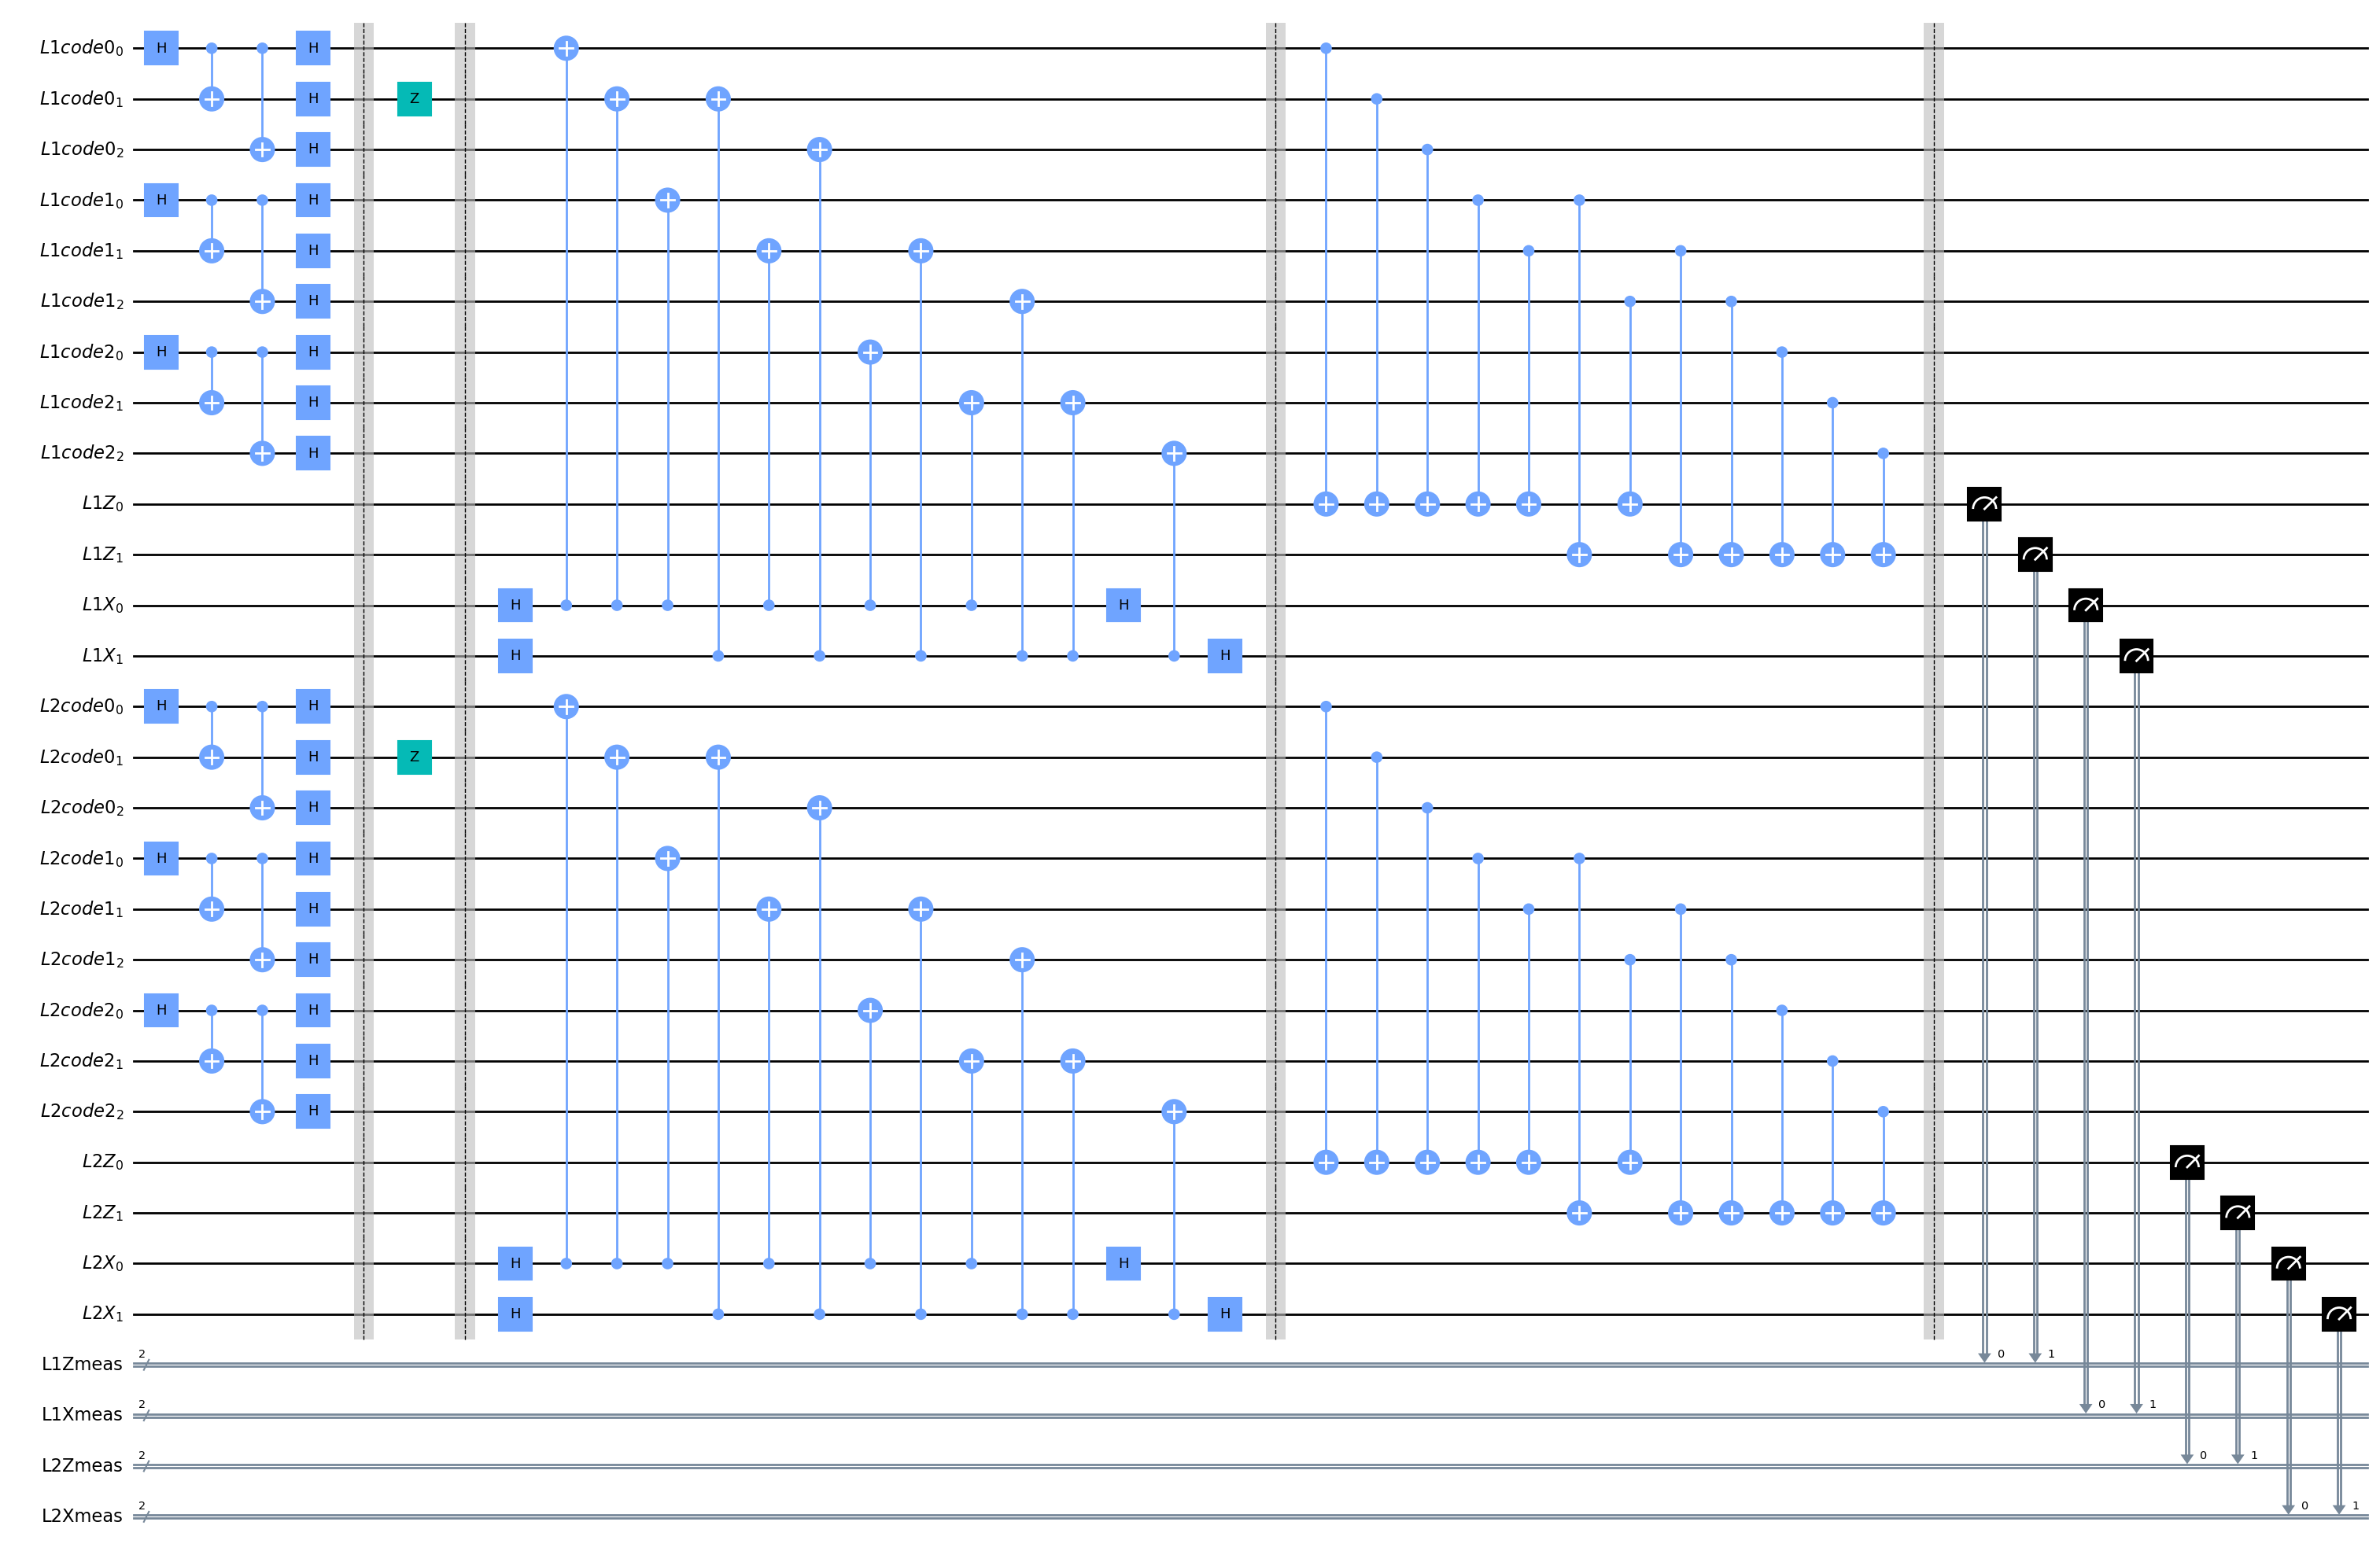

In [168]:
qc, qubits = createLogicalQubits(2)
L1Qubits, L1Ancilla = getQuibitArray(1, qc) 
L2Qubits, L2Ancilla = getQuibitArray(2, qc) 

applyEncoder(qc, qubits)
applyrandomError(qc, qubits)
applyXDetection(qc, qubits)
applyZDetection(qc, qubits)



circuit.append(x_stabilizers(), L1Qubits + L1Ancilla[2] + Ancilla[3])

# applyCodeMeasurements(qc, qubits)
applyMeasurements(qc, qubits)
qc.draw(output='mpl', fold=45)

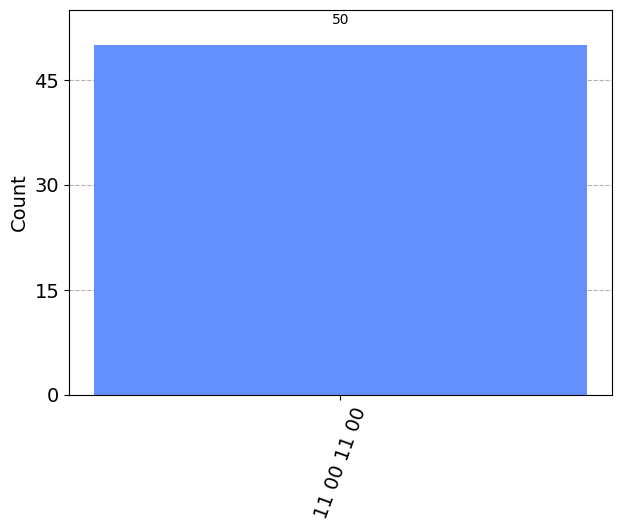

In [169]:
sim = Aer.get_backend('qasm_simulator')
job = execute(qc, sim, shots=50)
result = job.result()
counts = result.get_counts(qc)
# X stabilizers: If 01 => error is in first block of 3 code qubits, if 11 => error is in second block of 3 code qubits, if 10 => error is in third block of 3 code qubits
# Z stabilizers: If 01 => error is on 1st, 4th or 7th code qubit, if 11 => error is on 2nd, 5th or 8th code qubit, if 10 => error is on 3rd, 6th or 9th code qubit
visualization.plot_histogram(counts)

In [139]:
def cleanData(data):
    newData = {}
    for key in data:
        if key == '00 00 00 00':
            newData[key] = data[key]
    print(data)

cleanData(counts)

{'00 00 00 00': 5}
